In [1]:
import os
import pandas as pd
import time
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pywt
import seaborn as sns

from scipy.signal import correlate


Concatenating the files to get them into a dataframe.

In [2]:
folder_path = r"C:\Users\mirwa\Downloads\partition1_instances\partition1_instances\partition1\FL"

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
dfs_m_class = []
dfs_x_class = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, delimiter='\t')
    if file.startswith('M'):
        dfs_m_class.append(df)
    elif file.startswith('X'):
        dfs_x_class.append(df)
m_class_df = pd.concat(dfs_m_class, ignore_index=True)
x_class_df = pd.concat(dfs_x_class, ignore_index=True)

In [3]:
x = 4
m_class_new = m_class_df.iloc[:, :x]
m_class_new['class'] = 'M'
x_class_new = x_class_df.iloc[:, :x]
x_class_new['class'] = 'X'

concatenated_df = pd.concat([m_class_new, x_class_new], ignore_index=True)
concatenated_df.head()

,Timestamp,TOTUSJH,TOTBSQ,TOTPOT,class
0,2011-02-16 23:00:00,1315.120642,1.842497e+10,3.016901e+23,M
1,2011-02-16 23:12:00,1295.291384,1.843622e+10,3.024088e+23,M
2,2011-02-16 23:24:00,1291.072348,1.843172e+10,3.019023e+23,M
3,2011-02-16 23:36:00,1276.641067,1.844119e+10,2.997206e+23,M
4,2011-02-16 23:48:00,1290.970251,1.841171e+10,2.985437e+23,M


In [4]:
concatenated_df['Timestamp'] = pd.to_datetime(concatenated_df['Timestamp']) 
concatenated_df.set_index('Timestamp', inplace=True)
concatenated_df.head()

,TOTUSJH,TOTBSQ,TOTPOT,class
Timestamp,,,,
2011-02-16 23:00:00,1315.120642,1.842497e+10,3.016901e+23,M
2011-02-16 23:12:00,1295.291384,1.843622e+10,3.024088e+23,M
2011-02-16 23:24:00,1291.072348,1.843172e+10,3.019023e+23,M
2011-02-16 23:36:00,1276.641067,1.844119e+10,2.997206e+23,M
2011-02-16 23:48:00,1290.970251,1.841171e+10,2.985437e+23,M


Null value imputation.

In [5]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75240 entries, 2011-02-16 23:00:00 to 2011-08-09 00:00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TOTUSJH  75107 non-null  float64
 1   TOTBSQ   75107 non-null  float64
 2   TOTPOT   75107 non-null  float64
 3   class    75240 non-null  object 
dtypes: float64(3), object(1)
memory usage: 2.9+ MB


In [6]:
concatenated_df.isnull().sum()

TOTUSJH    133
TOTBSQ     133
TOTPOT     133
class        0
dtype: int64

In [7]:
rows_with_missing_values = concatenated_df[concatenated_df.isnull().any(axis=1)]

subset_columns = concatenated_df.columns.tolist()
subset_columns.remove('class')
concatenated_df[subset_columns] = concatenated_df[subset_columns].fillna(concatenated_df[subset_columns].mean())

concatenated_df.isnull().sum()

TOTUSJH    0
TOTBSQ     0
TOTPOT     0
class      0
dtype: int64

Temporal Correlation.

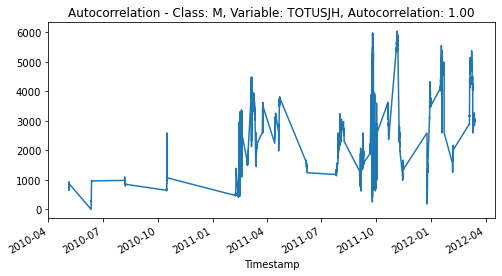

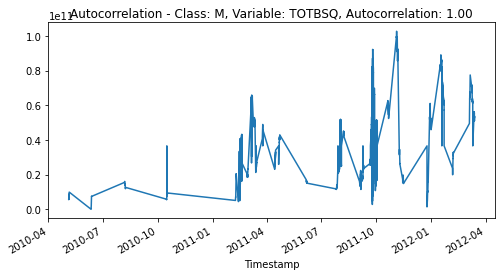

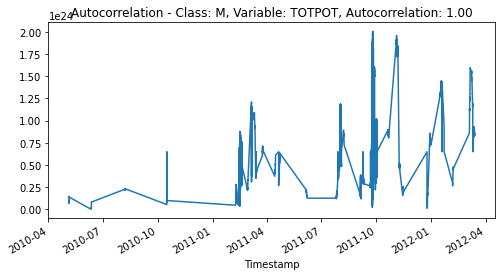

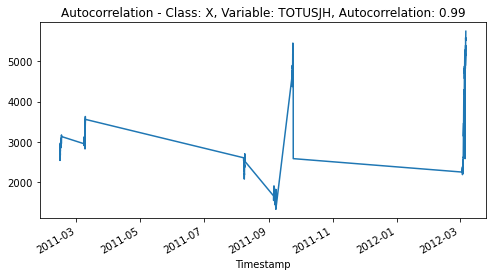

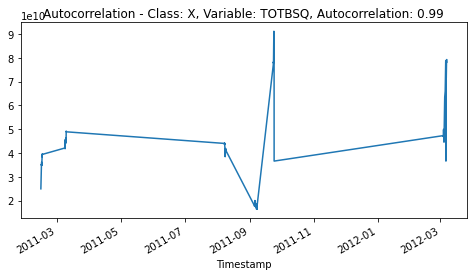

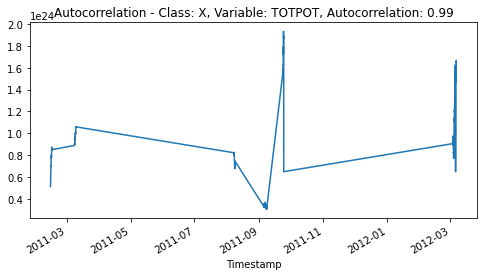

In [8]:
for class_name in concatenated_df['class'].unique():
    class_df = concatenated_df[concatenated_df['class'] == class_name]
    for column in class_df.columns[:-1]: 
        autocorrelation = class_df[column].autocorr()
        plt.figure(figsize=(8, 4))
        class_df[column].plot(title=f'Autocorrelation - Class: {class_name}, Variable: {column}, Autocorrelation: {autocorrelation:.2f}')
        plt.show()

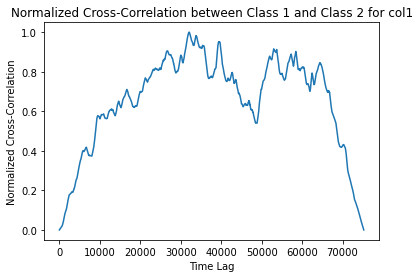

In [14]:
class_1_data = concatenated_df[concatenated_df['class'] == 'M']['TOTUSJH'].values
class_2_data = concatenated_df[concatenated_df['class'] == 'X']['TOTUSJH'].values
cross_corr = np.correlate(class_1_data, class_2_data, mode='full')
normalized_cross_corr = cross_corr / np.max(cross_corr)
plt.plot(normalized_cross_corr)
plt.title('Normalized Cross-Correlation between Class 1 and Class 2 for col1')
plt.xlabel('Time Lag')
plt.ylabel('Normalized Cross-Correlation')
plt.show()

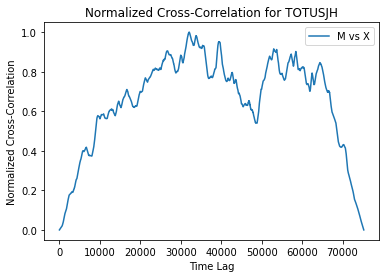

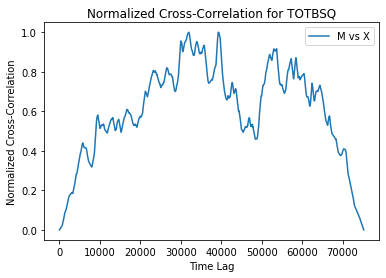

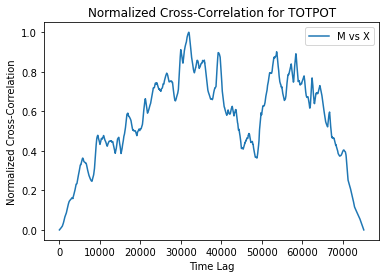

In [18]:
parameters = ['TOTUSJH', 'TOTBSQ', 'TOTPOT']
classes = concatenated_df['class'].unique()
for parameter in parameters:
    for class_1 in classes:
        for class_2 in classes:
            if class_1 != class_2 and class_1 == 'M':  
                class_1_data = concatenated_df[concatenated_df['class'] == class_1][parameter].values
                class_2_data = concatenated_df[concatenated_df['class'] == class_2][parameter].values
                cross_corr = np.correlate(class_1_data, class_2_data, mode='full')
                normalized_cross_corr = cross_corr / np.max(cross_corr)
                plt.plot(normalized_cross_corr, label=f'{class_1} vs {class_2}')
                plt.title(f'Normalized Cross-Correlation for {parameter}')
                plt.xlabel('Time Lag')
                plt.ylabel('Normalized Cross-Correlation')
                plt.legend()
                plt.show()
    
    